# RecB re-recruitment to DNA

In [1]:
from pyberries.data import DatasetPool, Fit, get_histogram
import seaborn.objects as so
from seaborn import plotting_context
import pandas as pd

data = (DatasetPool(path='/media/daniel/HDD Daniel/DanielThedie/BACMMAN/Timelapse',
                    dsList=['230725_1', '230725_2', '230126_DT23', '230719_1', '230719_2', '240424_1', '240612_1',
                            '230201_DT22', '230919_1', '240424_3', '240612_3',
                            '230126_DT21', '230919_2', '230920_2', '240606_1', '240606_3',
                            '230118_DT23', '230720_1', '230720_2', '230726_cipro30', '230824_1', '230829_1', '230201_DT23', '230504_2sec', '230718_2sec', '240424_2', '240612_2',
                            '221222_cipro30ngmL', '230802_DT22', '230808_DT22', '230914_1', '240424_4', '240612_4',
                            '230802_DT21', '230913_2', '230914_2', '240606_2', '240606_4'],
                    groups=['WT, 0', 'WT, 0', 'WT, 0', 'WT, 0', 'WT, 0', 'WT, 0', 'WT, 0',
                            'ΔrecA, 0', 'ΔrecA, 0', 'ΔrecA, 0', 'ΔrecA, 0',
                            'RecB1080, 0', 'RecB1080, 0', 'RecB1080, 0', 'RecB1080, 0', 'RecB1080, 0',
                            'WT, 30 ng/mL', 'WT, 30 ng/mL', 'WT, 30 ng/mL', 'WT, 30 ng/mL', 'WT, 30 ng/mL', 'WT, 30 ng/mL', 'WT, 30 ng/mL', 'WT, 30 ng/mL', 'WT, 30 ng/mL', 'WT, 30 ng/mL', 'WT, 30 ng/mL',
                            'ΔrecA, 30 ng/mL', 'ΔrecA, 30 ng/mL', 'ΔrecA, 30 ng/mL', 'ΔrecA, 30 ng/mL', 'ΔrecA, 30 ng/mL', 'ΔrecA, 30 ng/mL',
                            'RecB1080, 30 ng/mL', 'RecB1080, 30 ng/mL', 'RecB1080, 30 ng/mL', 'RecB1080, 30 ng/mL', 'RecB1080, 30 ng/mL'],
                    filters={'all':'Frame < 50'},
                    metadata='DateTime',
                    rename_objects={'Spot_detection':'RecB_spots'},
                    rename_cols={'SpotCount':'RecBSpotCount'}
                    )
        .assign(Time_min=lambda df: df.Time_min + 15)
        .bin_column(col='Time_min', binsize=15, binlabels='left')
        .split_column(col='Group', new_cols=['Strain', 'Cipro'], delimiter=', ')
        )

Dataset 230725_1 (group WT, 0): loaded objects ['Bacteria_large', 'RecB_spots', 'RecA', 'RecB_raw']
Dataset 230725_2 (group WT, 0): loaded objects ['Bacteria_large', 'RecB_spots', 'RecA', 'RecB_raw']
Dataset 230126_DT23 (group WT, 0): loaded objects ['Bacteria_large', 'RecB_spots', 'RecB_raw']
Dataset 230719_1 (group WT, 0): loaded objects ['Bacteria_large', 'RecB_spots', 'RecB_raw']
Dataset 230719_2 (group WT, 0): loaded objects ['Bacteria_large', 'RecB_spots', 'RecB_raw']
Dataset 240424_1 (group WT, 0): loaded objects ['Bacteria_large', 'RecB_spots', 'RecB_raw', 'Nucleoid']
Dataset 240612_1 (group WT, 0): loaded objects ['Bacteria_large', 'RecB_spots', 'RecB_raw', 'Nucleoid']
Dataset 230201_DT22 (group ΔrecA, 0): loaded objects ['Bacteria_large', 'RecB_spots', 'RecB_raw']
Dataset 230919_1 (group ΔrecA, 0): loaded objects ['Bacteria_large', 'RecB_spots', 'RecB_raw']
Dataset 240424_3 (group ΔrecA, 0): loaded objects ['Bacteria_large', 'RecB_spots', 'RecB_raw', 'Nucleoid']
Dataset 24061

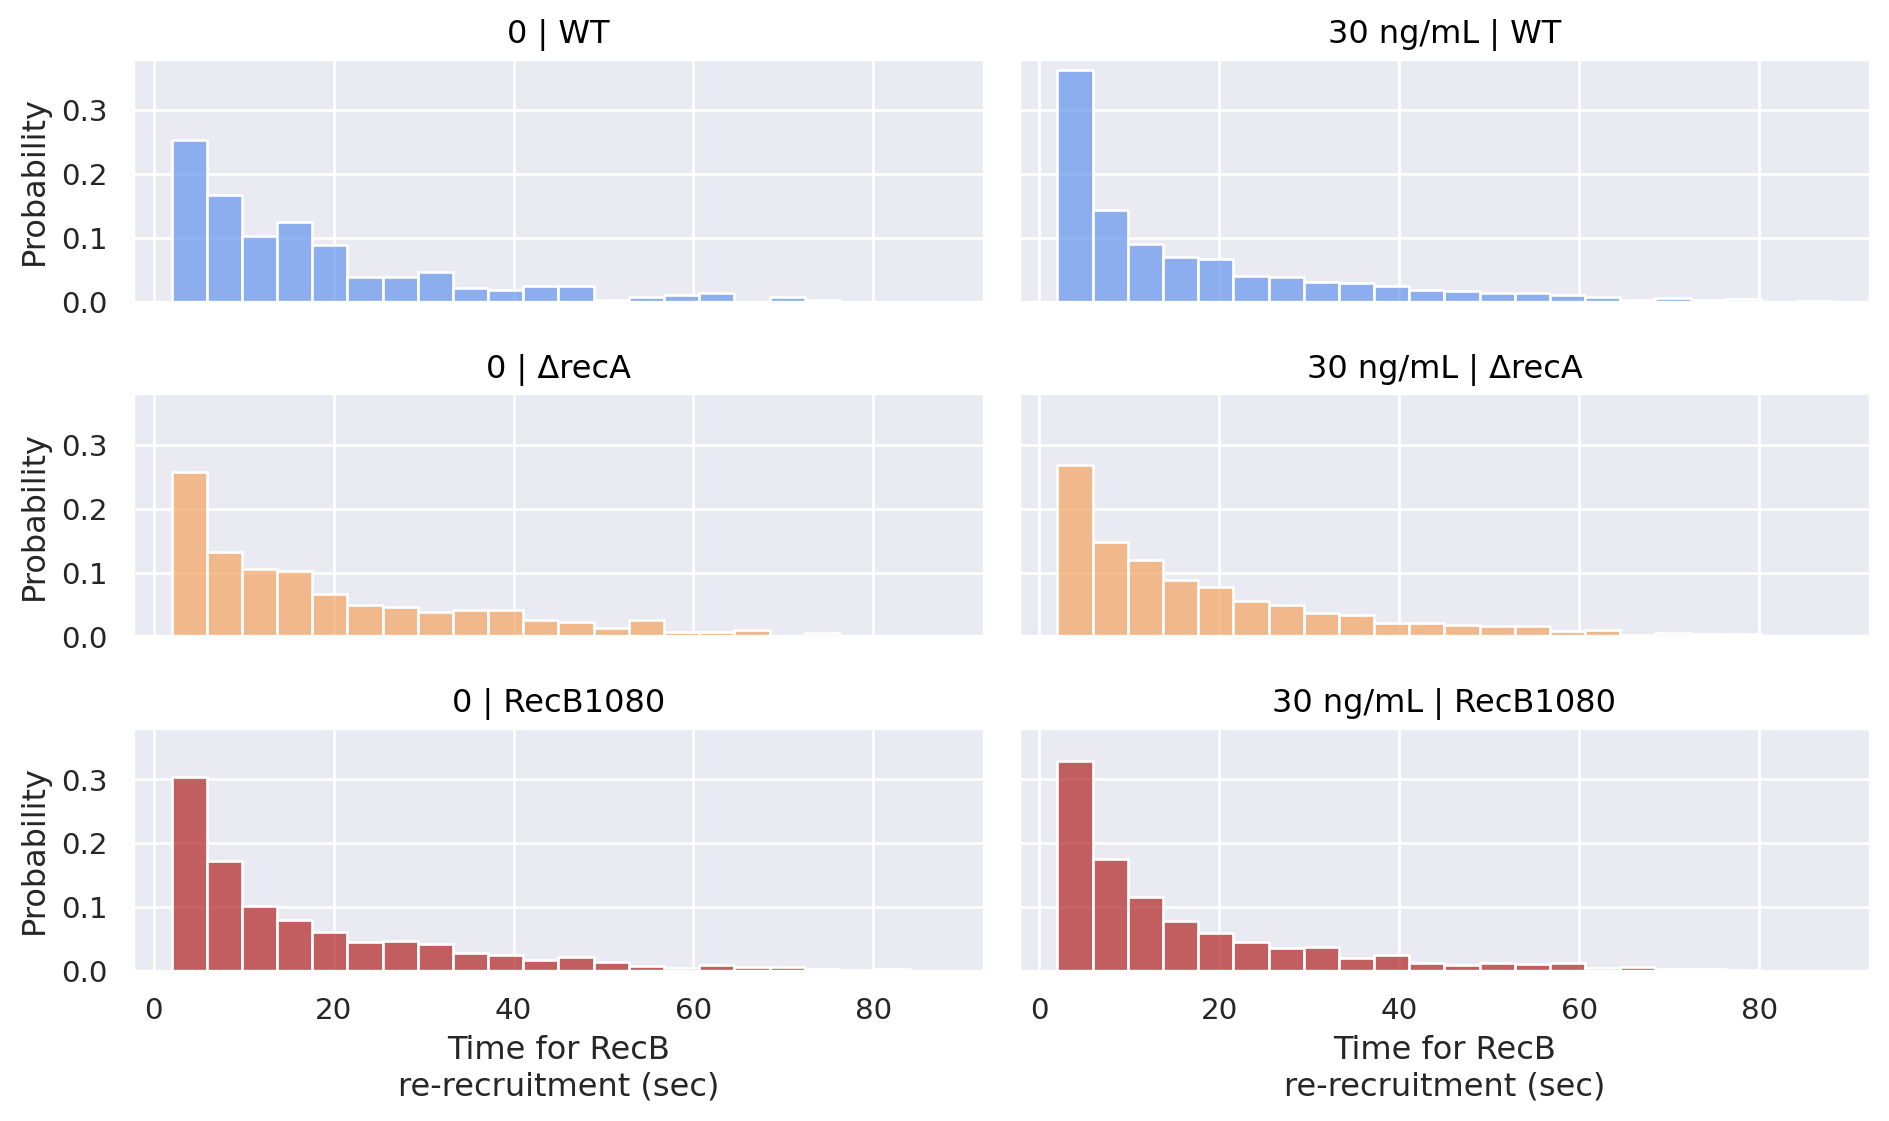

In [6]:
df = (data
      .get_parent_indices(object_name='RecB_spots')
      .split_column(object_name='RecB_spots', col='ParentIndices', delimiter='-', new_cols=['Frame_tmp', 'CellIdx'])
      .RecB_spots
      .query('TrackLength >= 5 and Frame > 0')
      # .query('Dataset == "230126_DT21" and Position == "Im001" and CellIdx == "11"')
      .groupby(['Strain', 'Cipro', 'Dataset', 'Position', 'CellIdx', 'TrackHeadIndices'], observed=True)
      .agg(spot_start=('Frame', 'min'), spot_end=('Frame', 'max'))
      .reset_index()
      .assign(multiple_spots=lambda df: df.duplicated(keep=False, subset=['Dataset', 'Position', 'CellIdx']))
      .query('multiple_spots == True')
      .sort_values('spot_start')
      .groupby(['Strain', 'Cipro', 'Dataset', 'Position', 'CellIdx'], observed=True)
      .agg(spot_start=('spot_start', lambda x: x.iloc[1]), spot_end=('spot_end', 'first'))
      .reset_index()
      .assign(interval=lambda df: (df.spot_start - df.spot_end)*2)
      .query('interval > 0')
      )

# display(df)

(
      so.Plot(df, x='interval', color='Strain')
      .facet(col='Cipro', row='Strain', order={'row':['WT', 'ΔrecA', 'RecB1080']})
      .layout(size=(10, 6))
      .add(so.Bars(), so.Hist(binwidth=4, common_norm=False, stat='probability'), legend=False)
      .scale(color=so.Nominal(['cornflowerblue', 'sandybrown', 'firebrick'], order=['WT', 'ΔrecA', 'RecB1080']))
      .label(x='Time for RecB\nre-recruitment (sec)', y='Probability')
      # .limit(y=(0, 0.05))
)